<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!python -m pip install rdkit-pypi

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd

In [88]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');

## Загружаем данные:

In [89]:
train_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
4978,4978,CN(C)CCNc1nc2cc(O)ccc2c2c1C(=O)c1ccccc1-2,True
5388,5388,COc1ccc(-c2cc(=O)c3c(OC)c(OC)c(OC)c(OC)c3o2)cc1OC,False
4621,4621,Cl.O=c1[nH]ccc2cc(OC3CCNCC3)ccc12,False
232,232,Cc1cc2sc(NC(=O)Cc3ccccc3)nc2cc1Cl,False
4168,4168,COc1ccc(C(=O)/C(Cc2cc(OC)c(OC)c(OC)c2)=C(\C(=O...,False


In [90]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = 0
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = False
test.columns = ['smiles', 'active']
test['is_test'] = 1

data = pd.concat([train, test]).reset_index(drop=True)

In [91]:
data.sample(5)

,smiles,active,is_test
6367,Nc1nncs1,False,1
1473,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=CCS[C...,False,0
286,CCCCC[C@H](O)CC[C@@H]1[C@H]2Cc3cccc(OCC(=O)O)c...,False,0
3395,C[C@@]1(C(=O)O)NCCc2cc(O)c(O)cc21,False,0
5889,CN1Cc2c(N)cccc2[C@H](c2ccccc2)C1,False,1


In [92]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [93]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Визуализируем активные молекулы:

In [94]:
# smiles_active = train.iloc[active_ind, :]['smiles'].values
# fig, axs = plt.subplots(25, 2, figsize=(10, 100))
# axs = axs.ravel()

# for i, smpl in enumerate(smiles_active[50:100]):
#     mol = Chem.MolFromSmiles(smpl)
#     im = Chem.Draw.MolToImage(mol)
#     print(f'{i}) {smpl}')
#     # plt.figure(figsize = (3, 3))
#     # axs(i) = plt.axes(frameon=True)
#     axs[i].imshow(im)
#     axs[i].axis('off');

## Модель 0 (random baseline)

In [95]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Генерация новых признаков

In [96]:
from rdkit.Chem.Descriptors import MolWt

def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_    

data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.MolFromSmiles(x)), 1))

atoms = ['C', 'c', 'O', 'o', 'N', 'N+', 'n', 'P', 'p',
         'S', 's', 'Cl', 'Br', 'F', '(']
for a in atoms:
    data = num_of_(data, a)

## Наивная логрегрессия

In [97]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

RND_SEED = 42

In [100]:
# разбиваем датасет на тренировку и валидацию
X = data[data['is_test'] == 0].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[data['is_test'] == 0, 'active']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

In [ ]:
# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=300, criterion="entropy",
                             max_depth=100, min_samples_split=2,
                             max_features="auto", bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

(0.1045751633986928, 0.0)

## Submission LogRegression

In [ ]:
submission = test.drop(['is_test', 'active'], axis=1).copy()

X_test = data[data['is_test'] == 1].drop(['is_test', 'smiles', 'active'], axis=1)
y_pred_test = lrgr.predict(X_test)

submission['Active'] = y_pred_test
submission.columns = ['Smiles', 'Active']
submission

# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,True
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,True


In [99]:
lrgr_cv = LogisticRegressionCV(Cs=10, cv=10, scoring='f1_score',
                               random_state=RND_SEED, 
                               l1_ratios=None)


CN(Cc1ccccc1)C(=O)[C@H](Cc1ccc2ccccc2c1)NC(=O)[C@@H]1CCCN1C(=O)Nc1ccccc1[N+](=O)[O-]


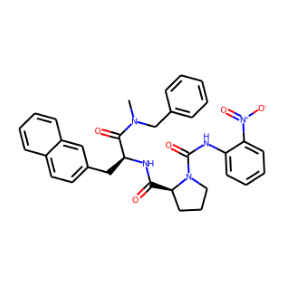

In [ ]:
smpl = train['smiles'][134]
mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}')
plt.figure(figsize = (5, 5))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [79]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);